In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
classification_report, precision_recall_curve, confusion_matrix, auc, average_precision_score, recall_score

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [4]:
df = pd.read_csv('hotel.csv')
df.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
print(f'% Пропусков - \ncompany - {round(df["company"].isna().sum()*100/df.shape[0],2)}\
\nagent - {round(df["agent"].isna().sum()*100/df.shape[0],2)} \ncountry - {round(df["country"].isna().sum()*100/df.shape[0],2)}\
\nchildren - {round(df["children"].isna().sum()*100/df.shape[0],3)}')

% Пропусков - 
company - 94.31
agent - 13.69 
country - 0.41
children - 0.003


### Работа с пропущенными значениями (отбрасываем признаки и данные)

In [7]:
df.drop(columns=['company','agent', 'arrival_date_month'], inplace= True)
df.dropna(subset=['country','children'], inplace= True )
df.reset_index(drop= True , inplace= True )

In [8]:
df.iloc[:, 1].value_counts()*100/df.shape[0]

0    62.864808
1    37.135192
Name: is_canceled, dtype: float64

### Pipelin классы

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [58]:
def evaluate_results(y_test, y_predict):
    results = {}
    results['f1']= round((f1_score(y_test, y_predict) * 100.0),2)
    results['roc']= round((roc_auc_score(y_test, y_predict)*100),2)
    results['rec']= round((recall_score(y_test, y_predict, average='binary')*100),2)
    results['prc']= round((precision_score(y_test, y_predict, average='binary')*100),2) 
    return results


In [11]:
categorical_columns = [el for el in df.columns if df[el].dtype == object]
continuous_columns = [el for el in df.columns if df[el].dtype != object]
continuous_columns.remove('is_canceled')
categorical_columns.remove('reservation_status')
# reservation_status - содержит целевой признак is_canceled

In [14]:
def make_pipline(categorical_columns, continuous_columns):
    final_transformers = []

    for cat_col in categorical_columns:
        cat_transformer = Pipeline([
            ('selector', FeatureSelector(column=cat_col)),
            ('ohe', OHEEncoder(key=cat_col))])
        final_transformers.append((cat_col, cat_transformer))
        
    for cont_col in continuous_columns:
        cont_transformer = Pipeline([
            ('selector', NumberSelector(key=cont_col))])
        final_transformers.append((cont_col, cont_transformer))
            
            
    # обьединяем трансформаторы кактегориальных и числовых признаков
    feats = FeatureUnion(final_transformers)
    return feats
feats = make_pipline(categorical_columns, continuous_columns)

In [15]:
y = df.iloc[:,1]
X = df.drop(columns=['is_canceled'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [16]:
pipeline = Pipeline([
        ('features', feats),
        ('classifier', XGBClassifier()),
    ])
pipeline.fit(X_train, y_train)
score = pipeline.predict_proba(X_test)[:, 1]
preds = pipeline.predict(X_test)

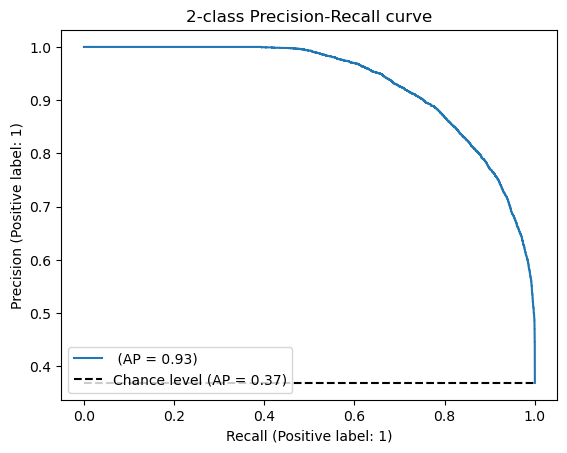

In [17]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test, name="", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [60]:
supervised_metrics = evaluate_results(y_test,preds)
supervised_metrics

{'f1': 83.25, 'roc': 86.44, 'rec': 80.02, 'prc': 86.76}

### Манипуляции с классом, создания неразмеченого множества из истино негативного класа и части положительного класса

In [19]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 11039/44153 as positives and unlabeling the rest


In [20]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    107859
 1     11039
Name: class_test, dtype: int64


In [21]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [22]:
X_semi_labeling = mod_data.drop(columns=['class_test', 'is_canceled'])
y_semi_labeling = mod_data.iloc[:,-1].values # полуразмеченые метки класса в котором во множество - класса ввели часть + образцов (без возврата)
y = mod_data.iloc[:,1].values # исходная разметка классов, классы как они и были до нашего вмешательства

### Новый Pipline для Semilabling Supervisor  
###  random negative sampling

In [39]:
categorical_columns = [el for el in mod_data.columns if mod_data[el].dtype == object]
continuous_columns = [el for el in mod_data.columns if mod_data[el].dtype != object]
continuous_columns.remove('is_canceled')
continuous_columns.remove('class_test')
categorical_columns.remove('reservation_status')

feats_2 = make_pipline(categorical_columns, continuous_columns)
pipeline_2 = Pipeline([
        ('features', feats_2),
        ('classifier', XGBClassifier()),
    ])

In [40]:
pipeline_2

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hotel',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='hotel')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='hotel'))])),
                                                ('meal',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='meal')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='meal'))])),
                                                ('country',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='country')),
                                                                 ('ohe',
                                                                  OHE...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [32]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(11039, 30) (11039, 30)


In [53]:
sample_train_2_X = sample_train.drop(columns=['is_canceled','class_test'])
sample_train_2_y = sample_train['is_canceled']

sample_test_2_X = sample_test.drop(columns=['is_canceled','class_test'])
sample_test_2_y = sample_test['is_canceled']

In [62]:
pipeline_2.fit(sample_train_2_X, sample_train_2_y)
predict = pipeline_2.predict(sample_test_2_X)


In [64]:
semi_suprvised_rns_25 = evaluate_results(sample_test_2_y, predict)
semi_suprvised_rns_25 

{'f1': 75.17, 'roc': 84.39, 'rec': 92.9, 'prc': 63.12}

In [97]:
col_for_drop = ['is_canceled','class_test']
def rns(percentile, df, col_for_drop, target_col = 'is_canceled'):
    mod_data = df.copy()
    #get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,1].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(percentile * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]
    
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    sample_train_2_X = sample_train.drop(columns=col_for_drop)
    sample_train_2_y = sample_train[target_col]
    sample_test_2_X = sample_test.drop(columns=col_for_drop)
    sample_test_2_y = sample_test[target_col]
    
    return sample_train_2_X, sample_train_2_y, sample_test_2_X, sample_test_2_y

### 10 % выборки положительного класа добавим к неразмеченым образцам

In [105]:
sample_train_2_X, sample_train_2_y, sample_test_2_X, sample_test_2_y = rns(0.1, df, col_for_drop)

In [108]:
pipeline_2.fit(sample_train_2_X, sample_train_2_y)
predict = pipeline_2.predict(sample_test_2_X)

In [109]:
semi_suprvised_rns_10 = evaluate_results(sample_test_2_y, predict)
semi_suprvised_rns_10 

{'f1': 75.23, 'roc': 82.13, 'rec': 93.63, 'prc': 62.87}

### 50 % выборки положительного класа добавим к неразмеченым образцам

In [110]:
sample_train_2_X, sample_train_2_y, sample_test_2_X, sample_test_2_y = rns(0.5, df, col_for_drop)

In [111]:
pipeline_2.fit(sample_train_2_X, sample_train_2_y)
predict = pipeline_2.predict(sample_test_2_X)

In [112]:
semi_suprvised_rns_50 = evaluate_results(sample_test_2_y, predict)
semi_suprvised_rns_50 

{'f1': 70.29, 'roc': 85.79, 'rec': 92.31, 'prc': 56.75}

### Сводная таблица

In [119]:
metrics_df = pd.DataFrame(supervised_metrics.values(), index=supervised_metrics.keys(), columns=['Suprvised Model'])
metrics_df.insert(loc=len(metrics_df.columns), column='Semi suprvised RNS 10 % positive to negative', value=semi_suprvised_rns_10.values())
metrics_df.insert(loc=len(metrics_df.columns), column='Semi suprvised RNS 25 % positive to negative', value=semi_suprvised_rns_25.values())
metrics_df.insert(loc=len(metrics_df.columns), column='Semi suprvised RNS 50 % positive to negative', value=semi_suprvised_rns_50.values())
metrics_df

,Suprvised Model,Semi suprvised RNS 10 % positive to negative,Semi suprvised RNS 25 % positive to negative,Semi suprvised RNS 50 % positive to negative
f1,83.25,75.23,75.17,70.29
roc,86.44,82.13,84.39,85.79
rec,80.02,93.63,92.90,92.31
prc,86.76,62.87,63.12,56.75


Даже небольшое перемещение 10 % даных положительного класса к неразмеченым данным веедет к значительному падению метрики, около 9%. Однако дальнейшие падение в качестве, при увеличение % семплирования замедляется и даже при семплировании 50 % f score имеет вполне адекватные значения.  
Как видим RNS хорошо работает с большими данными к которым можно отнести набор данных - отмены бронирования в отелях  
(содержащий  - 119 390 строк) так как такие данные в большей мере соответсвуют генеральной совокупности